In [1]:
# ==============================================================================
# Celda 1: Importaciones
# ==============================================================================
import os
import logging
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show

# --- Importar los módulos de nuestro paquete LCP ---
from lcp_parallel_tile import config, orchestrator, geoutils, utils

print("Módulos y librerías cargados exitosamente.")

Módulos y librerías cargados exitosamente.


In [2]:
# ==============================================================================
# Celda 2: Configuración del Análisis
# --- AJUSTE AQUÍ TODOS LOS PARÁMETROS DE SU EJECUCIÓN ---
# ==============================================================================
import rasterio
import math
import os

# --- Importar el módulo de configuración de nuestro paquete ---
from lcp_parallel_tile import config

# --- Rutas ---
config.BASE_DIR = os.getcwd()
config.BASE_PROCESSING_FOLDER = os.path.join(config.BASE_DIR, 'output')
config.DATA_DIR = os.path.join(r'G:\LCP-data')
config.COST_RASTER_PATH = os.path.join(config.DATA_DIR, 'cost.tif')

# --- [MODIFICACIÓN] Añadir la ruta a la máscara ---
# Establecer en None para desactivar el uso de la máscara.
config.MASK_SHAPEFILE_PATH = os.path.join(config.DATA_DIR, 'poligono_extendido_cortado_disuelto.shp')

# --- [INICIO DE LÓGICA ADAPTATIVA] ---
# 1. Defina el tamaño MÁXIMO deseado para cada tile.
MAX_TILE_SIZE = 1000

# 2. Leemos las dimensiones del raster para calcular el tamaño de tile adaptativo.
with rasterio.open(config.COST_RASTER_PATH) as src:
    raster_width = src.width
    raster_height = src.height

# 3. Calculamos el número mínimo de tiles necesarios en cada eje.
num_tiles_x = math.ceil(raster_width / MAX_TILE_SIZE)
num_tiles_y = math.ceil(raster_height / MAX_TILE_SIZE)

# 4. Calculamos el tamaño real del tile para que cubra todo el raster de forma uniforme.
adaptive_tile_size = math.ceil(max(raster_width / num_tiles_x, raster_height / num_tiles_y))

# 5. Asignamos el valor calculado a la configuración.
config.TILE_SIZE = adaptive_tile_size
# --- [FIN DE LÓGICA ADAPTATIVA] ---

# --- Parámetros de Nodos ---
config.NODE_SPACING = 200

# --- Parámetros de Cálculo Jerárquico (Valores Corregidos) ---
config.DOWNSAMPLING_FACTORS = [32, 20, 10]
config.CORRIDOR_BUFFER_PIXELS = 150

# --- Parámetros de Ejecución ---
config.N_JOBS = -2

# Guardamos la configuración de la sesión en una variable global para usarla más tarde
LATEST_SESSION_DIR = None 

print("Parámetros de configuración listos para la ejecución.")
print(f"-> Ruta de la máscara: {config.MASK_SHAPEFILE_PATH if config.MASK_SHAPEFILE_PATH else 'No se usará máscara'}")
print(f"-> Tamaño máximo de tile solicitado: {MAX_TILE_SIZE}x{MAX_TILE_SIZE} px")
print(f"-> Dimensiones del raster: {raster_width}x{raster_height} px")
print(f"-> TAMAÑO DE TILE ADAPTATIVO CALCULADO: {config.TILE_SIZE}x{config.TILE_SIZE} px")
print(f"Los resultados se guardarán dentro de: {config.BASE_PROCESSING_FOLDER}")

Parámetros de configuración listos para la ejecución.
-> Ruta de la máscara: G:\LCP-data\poligono_extendido_cortado_disuelto.shp
-> Tamaño máximo de tile solicitado: 1000x1000 px
-> Dimensiones del raster: 17209x19439 px
-> TAMAÑO DE TILE ADAPTATIVO CALCULADO: 972x972 px
Los resultados se guardarán dentro de: G:\LCP-parallel-tile\output


Generando previsualización de la segmentación del raster...


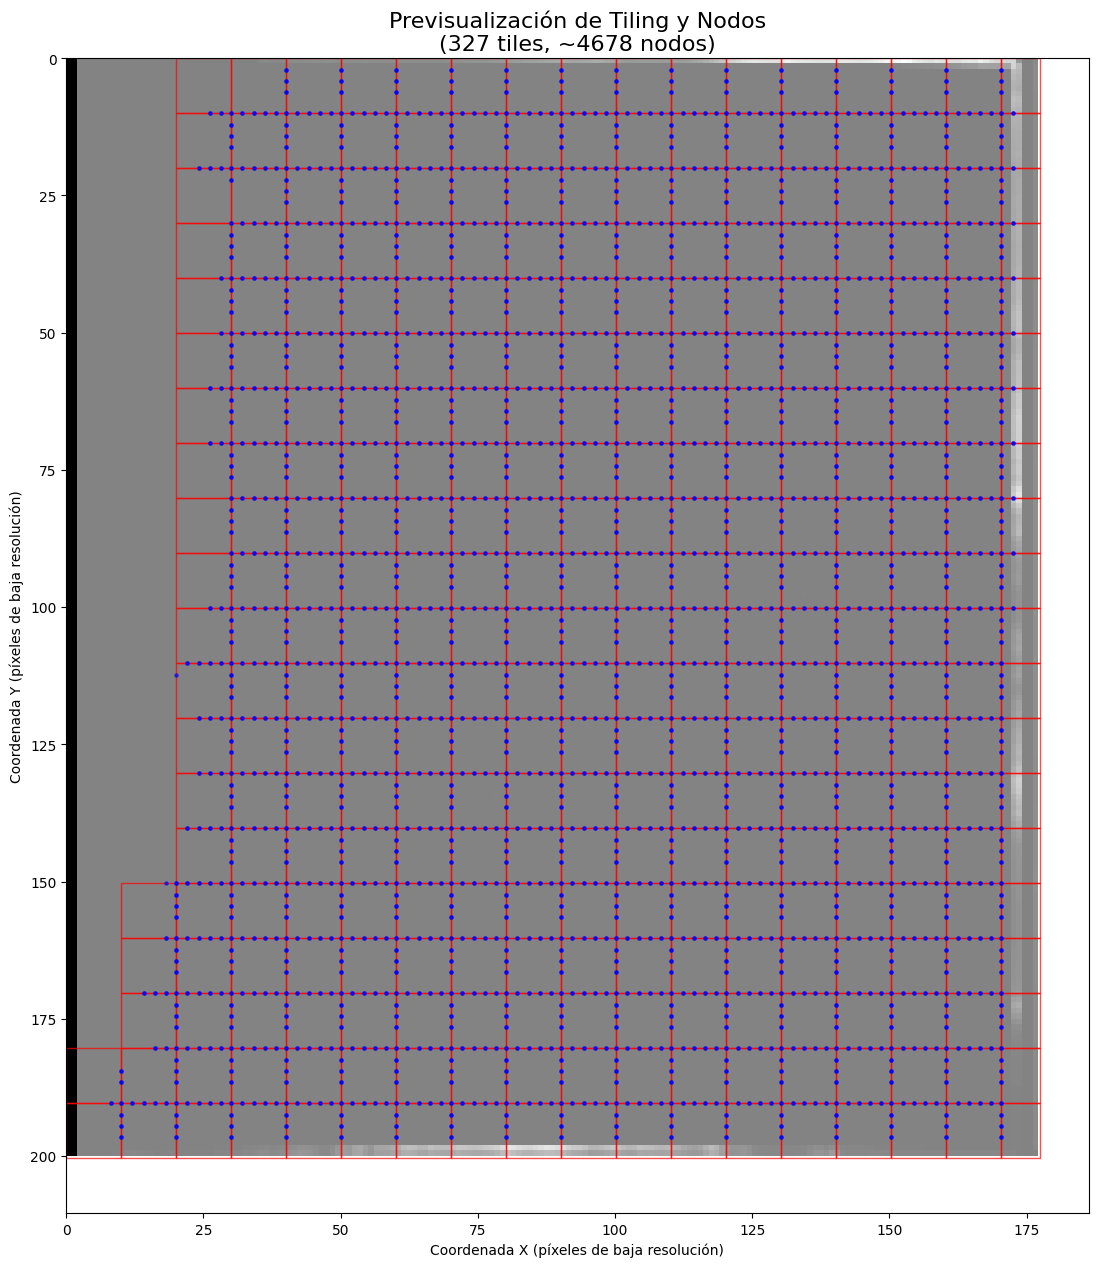

In [3]:
# ==============================================================================
# Celda 3: Visualización Previa de la Cuadrícula de Tareas
# ==============================================================================

# Llamamos a la función de visualización de nuestro paquete. ¡Limpio y simple!
geoutils.visualize_tiling_setup(config)

In [ ]:
# ==============================================================================
# Celda 4: Ejecución del Análisis Paralelo
# ==============================================================================

# --- Configurar el logger maestro que se mostrará en la consola del notebook ---
main_log = logging.getLogger("MasterLogger"); main_log.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
if not main_log.handlers:
    # Usamos el Tqdm handler de nuestro paquete de utilidades
    master_ch = utils.TqdmLoggingHandler(); master_ch.setFormatter(formatter)
    main_log.addHandler(master_ch)

try:
    # --- Llamada principal al orquestador ---
    # Le pasamos el objeto de configuración que definimos en la Celda 2.
    # El orquestador nos devuelve la ruta a la sesión para poder usarla después.
    LATEST_SESSION_DIR = orchestrator.run_analysis(config)
    
except Exception as e:
    main_log.critical("Ha ocurrido un error irrecuperable en la ejecución.", exc_info=True)
finally:
    main_log.info("================== EJECUCIÓN FINALIZADA ==================\n\n")

2025-09-19 01:35:05,295 - INFO - Iniciando Fase 1: Preparación de tareas de tiling y nodos de borde...
2025-09-19 01:35:05,296 - INFO - Cargando polígono de máscara desde: poligono_extendido_cortado_disuelto.shp
2025-09-19 01:35:06,244 - INFO - Preparación completa. Se generaron 327 tareas de tile con nodos válidos.
2025-09-19 01:35:06,253 - INFO - MODO REANUDACIÓN: Reanudando sesión 'flow_network_session_20250919_012927'.
2025-09-19 01:35:06,254 - INFO - 0 tiles ya completados.
2025-09-19 01:35:06,254 - INFO - Se procesarán 327 tiles pendientes en esta ejecución.


Procesando Tiles:   9%|█████▊                                                         | 30/327 [00:17<02:55,  1.69it/s]

In [ ]:
# ==============================================================================
# Celda 5: Carga y Visualización de la Red de Flujo Completa
# ==============================================================================

if LATEST_SESSION_DIR and os.path.exists(LATEST_SESSION_DIR):
    final_gpkg_path = os.path.join(LATEST_SESSION_DIR, "red_de_flujo_completa.gpkg")
    
    if os.path.exists(final_gpkg_path):
        print(f"Cargando la red de flujo desde: {final_gpkg_path}")
        network_gdf = gpd.read_file(final_gpkg_path)

        with rasterio.open(config.COST_RASTER_PATH) as src:
            fig, ax = plt.subplots(figsize=(18, 18))
            show(src, ax=ax, cmap='viridis', alpha=0.8) # Visualizar el raster completo
            network_gdf.plot(ax=ax, edgecolor='white', linewidth=0.2, alpha=0.5)
            ax.set_title("Red de Flujo de Menor Coste del Paisaje", fontsize=16)
            plt.show()
    else:
        print(f"Análisis completado, pero no se encontró el archivo de resultados fusionado en: {final_gpkg_path}")
else:
    print("No se ha ejecutado ninguna sesión de análisis todavía. Por favor, ejecute la celda anterior.")